# Describe circuit activity

**Highlights**:

* 854 neurons
* 0.07% of `S1FL` region
* Layers 3 to 6
* Are all the cells from the 30K cells microcircuit, the `hex0` group?


**Questions**: 

* why do the spike waveforms look so poor?
    * background noise produced by neighboring cells and recorded by the probe's contact likely distorts the true spike waveform. Can we plot the raw spike waveform extracted from the change in membrane potential simulated by NEURON?
* what criterion is used to decide when a spike is timestamped? 
* a spike is recorded by multiple nearby channels? What criterion is used to decide from which channel one should extract the "final" waveform?
    * likely the closest channel, where the spike amplitude should be maxinmal
* the simulation produces 30 trace and spike files ("pieces") that contain activity for 851 neurons. How were these neurons chosen?
* How well can we estimate the ground truth neurons known locations from their spike train and the recorded traces with the "center of mass" method?

**Notes**:

* Even one 4 sec piece of simulation is too large to be loaded at runtime in memory with report.get() on a compute node in interactive mode (with --mem=0). The associated lfp.h5 is 1.2TB.

## Setup

[TODO]
- pretty print the config with indents

In [6]:
# SETUP PACKAGES
%load_ext autoreload
%autoreload 2
import os
import pprint as pp
import pandas as pd
import yaml
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as spost
from probeinterface.plotting import plot_probe

pd.set_option('display.max_colwidth', None)

# set project path
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"

os.chdir(PROJ_PATH)
from src.pipelines.simulation.dataeng.loading import load_params_for_one_simulation_piece
from src.pipelines.simulation.sorting import ground_truth
from src.pipelines.simulation.dataeng import loading_raw_recording
from src.pipelines.simulation.preprocessing import silico_preprocess

from src.nodes.utils import get_config


# SETUP PARAMETERS
# the date of the simulation to run
SIMULATION_DATE = "2022_10_28"


# SETUP CONFIG
print("CONFIG:\n")
config = get_config(SIMULATION_DATE)
pp.pprint(config["dataset_conf"])
pp.pprint(config["param_conf"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CONFIG:

{'input': {'one_piece': '/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/spikeDetection/1f039ca3-7c27-4e0f-866e-e001f95620f4/0/BlueConfig',
           'simulated_traces_and_spikes': '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/output/0_silico/Hex0_4s_reyes128_0/results/',
           'simulation_path': '/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/spikeDetection/1f039ca3-7c27-4e0f-866e-e001f95620f4/0',
           'waveform_path': '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/output/0_silico/Hex0_4s_reyes128/Hex0_4s_reyes128_real_wfs',
           'weightspath': '/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/coeffsreyespuerta.h5'},
 'output': {'ground_truth_sorting_object': {'write_path': '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/output/0_silico/Hex0_4s_reyes128/Hex0_4s_reyes128_true_spikes'},
            'out': '/gpfs/bbp.cscs.ch/project/proj68

In [7]:
# load simulation
simulation = load_params_for_one_simulation_piece(config["dataset_conf"], config["param_conf"])

# get ground truth spikeinterface's sorting object
output = ground_truth.run(simulation, config["dataset_conf"], config["param_conf"])
sorting_object = output["ground_truth_sorting_object"]
params = output["params"]

# inspect object
print(f"object type: {type(sorting_object)}\n")
print(f"object attributes: \n")
print(dir(sorting_object))

object type: <class 'spikeinterface.core.npzfolder.NpzFolderSorting'>

object attributes: 

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_annotations', '_check_segment_index', '_extra_metadata_from_folder', '_extra_metadata_to_folder', '_features', '_get_file_path', '_kwargs', '_main_annotations', '_main_features', '_main_ids', '_main_properties', '_npz_kwargs', '_preferred_mp_context', '_properties', '_recording', '_sampling_frequency', '_save', '_sorting_segments', 'add_sorting_segment', 'annotate', 'check_if_dumpable', 'clone', 'copy_metadata', 'default_missing_property_values', 'delete_property', 'dump', 'dump_to_json', 'dump_to_pickle', 'extra_requirements', 'extractor_name', 'frame_sl

## Validate raw traces

### Get traces info

In [9]:
# load recording
simulated_traces = loading_raw_recording.load(config["dataset_conf"], config["param_conf"])

# inspect object
print(f"object type: {type(simulated_traces)}")
print(f"object attributes: \n")
print(dir(simulated_traces))

# inspect the raw recording
duration = simulated_traces.get_total_duration()
print(f"trace recording duration: {duration} secs")
print(f"channel (count): {simulated_traces.get_num_channels()} channels")
print(f"channel 2D locations: {simulated_traces.get_channel_locations()}")

object type: <class 'spikeinterface.core.numpyextractors.NumpyRecording'>
object attributes: 

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_annotations', '_channel_slice', '_check_segment_index', '_dtype', '_extra_metadata_from_folder', '_extra_metadata_to_folder', '_features', '_frame_slice', '_get_file_path', '_kwargs', '_main_annotations', '_main_features', '_main_ids', '_main_properties', '_preferred_mp_context', '_properties', '_recording_segments', '_remove_channels', '_sampling_frequency', '_save', '_select_segments', 'add_recording_segment', 'annotate', 'binary_compatible_with', 'channel_ids', 'channel_slice', 'check_if_dumpable', 'clear_channel_groups', 'clear_channel_locations', 

### Validate that raw traces are realistic

<Figure size 2000x1000 with 0 Axes>

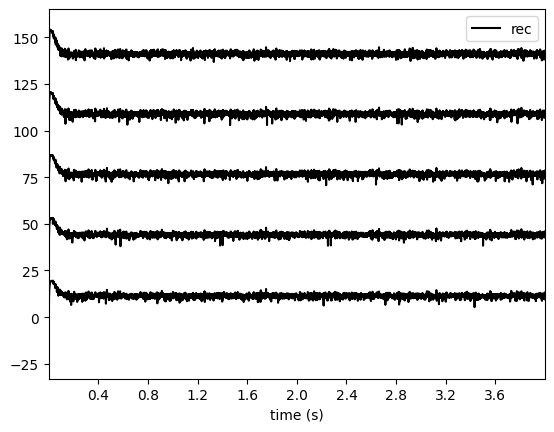

In [10]:
# Show example of the traces recorded from the five first channels
fig = plt.figure(figsize=(20,10));
sw.plot_timeseries(simulated_traces, channel_ids = [0,1,2,3,4], time_range = (0,duration));

### Validate that traces from nearby channels are more correlated than those from distant ones

In [11]:
# inspect the probe's contact channels' locations
probe = simulated_traces.get_probe()

Probe - 128ch - 1shanks
Probe coordinates and info:


,x,y,z,contact_shapes,radius,shank_ids,contact_ids
0,3333.812424,-1841.700930,-2641.781313,circle,12.5,,
1,3378.990145,-1853.023930,-2582.995573,circle,12.5,,
2,3424.167866,-1864.346930,-2524.209833,circle,12.5,,
3,3469.345587,-1875.669930,-2465.424093,circle,12.5,,
4,3514.523308,-1886.992930,-2406.638353,circle,12.5,,
...,...,...,...,...,...,...,...
123,4171.125433,-608.256736,-1995.138175,circle,12.5,,
124,4216.303153,-619.579736,-1936.352435,circle,12.5,,
125,4261.480874,-630.902736,-1877.566695,circle,12.5,,
126,4306.658595,-642.225736,-1818.780955,circle,12.5,,


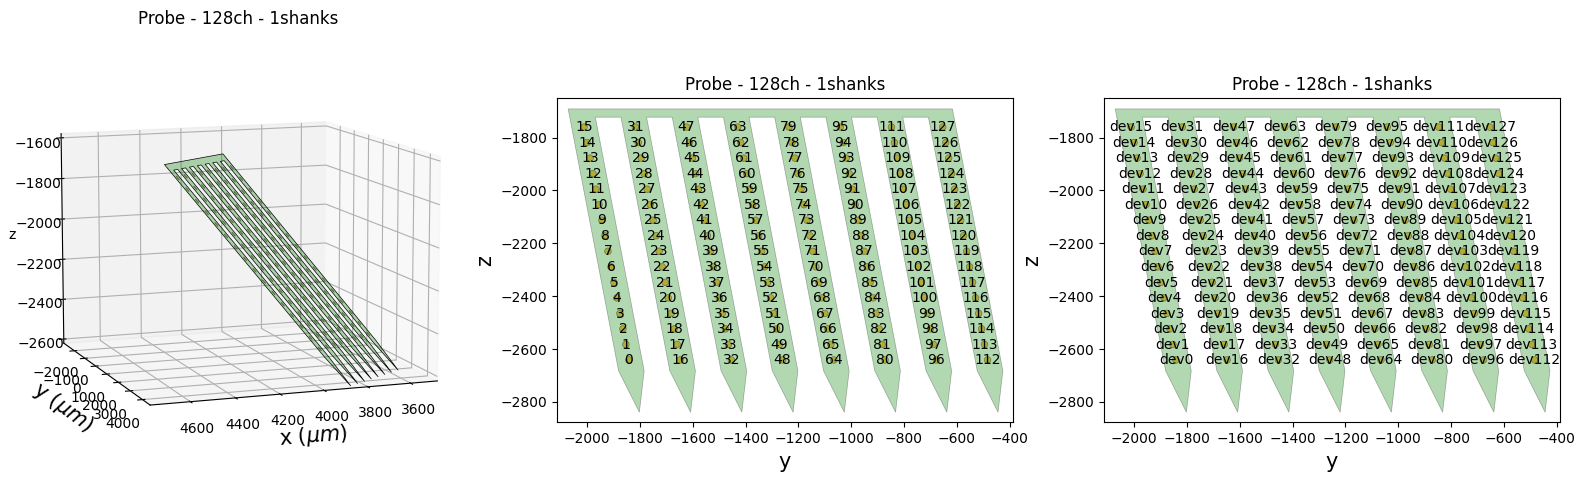

In [12]:
# View in contact channe locations in 3D
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(131, projection='3d')
ax.view_init(10, 70)
plot_probe(probe, ax=ax);
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);

# plot channel id on projection to the y-z 2D plan 
ax = fig.add_subplot(132)
plot_probe(probe.to_2d(axes='yz'), ax=ax, with_channel_index=True);
ax.set_xlabel("y");
ax.set_ylabel("z");

# plot channel id on the device
ax = fig.add_subplot(133)
plot_probe(probe.to_2d(axes='yz'), ax=ax, with_device_index=True);
ax.set_xlabel("y");
ax.set_ylabel("z");

print(probe)
print("Probe coordinates and info:")
probe.to_dataframe()

In [13]:
# sanity check the mapping between channel location and traces:
# The expectation is that contact traces near each other will be more correlated than distant ones
traces = simulated_traces.get_traces()
df = pd.DataFrame(np.corrcoef(traces.T))
corr = df.corr()
print("channel ids (cols) against channel ids (rows)")
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

channel ids (cols) against channel ids (rows)


/tmp/ipykernel_189748/932485474.py:7: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


# Describe ground truth units

In [14]:
cell_properties = simulation["circuit"].cells.get(sorting_object.unit_ids, properties=[ 
    'x','y','z',
    'etype',
    'exc_mini_frequency',
    'inh_mini_frequency',
    'layer',
    'me_combo',
    'morph_class',
    'morphology',
    'mtype',
    'orientation',
    'region',
    'synapse_class'])

## Describe the cells near the probe (851)

In [16]:
# count selected cells
unit_count = sorting_object.get_num_units()
print("Cells (count): ", unit_count)

# count cells in proportion to number of cells in S1FL
n_unit_S1FL = len(simulation["circuit"].cells.ids(group="S1FL"))
print("Cells (% of S1FL): ", unit_count/n_unit_S1FL*100)

# report properties of the selected population
categorical_properties = ["region", "layer", "morph_class", "synapse_class", "etype", "mtype", "me_combo", "morphology"]
pd.DataFrame(cell_properties[categorical_properties].apply(set), columns=["unique values"])

Cells (count):  854
Cells (% of S1FL):  0.07904531036391386


unique values
region                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [17]:
print(dir(sorting_object))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_annotations', '_check_segment_index', '_extra_metadata_from_folder', '_extra_metadata_to_folder', '_features', '_get_file_path', '_kwargs', '_main_annotations', '_main_features', '_main_ids', '_main_properties', '_npz_kwargs', '_preferred_mp_context', '_properties', '_recording', '_sampling_frequency', '_save', '_sorting_segments', 'add_sorting_segment', 'annotate', 'check_if_dumpable', 'clone', 'copy_metadata', 'default_missing_property_values', 'delete_property', 'dump', 'dump_to_json', 'dump_to_pickle', 'extra_requirements', 'extractor_name', 'frame_slice', 'from_dict', 'get_all_spike_trains', 'get_annotation', 'get_annotation_keys', 'get_num

# Describe a unit

In [18]:
sorted_units = sorted(sorting_object.get_total_num_spikes().items(), key=lambda x:x[1])
print("a mildly active unit: ", sorted_units[-10])

a mildly active unit:  (3942311, 13)


## Validate its spikes

In [19]:
# run preprocessing
preprocessed_traces = silico_preprocess.run(config["dataset_conf"], config["param_conf"])
print("total samples (count):", preprocessed_traces.get_traces().shape[0])

write_binary_recording with n_jobs = 1 and chunk_size = None
total samples (count): 79990


### Validate that the spikes are visible on nearby channels' traces

In [20]:
# get most active unit
most_active_unit_id = max(sorting_object.get_total_num_spikes(), key=sorting_object.get_total_num_spikes().get)
spike_count = sorting_object.get_total_num_spikes()[most_active_unit_id]
print("most active unit: ", most_active_unit_id)
print("spikes (count): ", spike_count)

most active unit:  1364637
spikes (count):  29


## Locate it

#### Load its true location

In [21]:
most_active_unit_true_loc = simulation["circuit"].cells.get(most_active_unit_id, properties=["x","y","z"])

#### Estimate its location

In [22]:
# localize the most active unit
# create waveform extractor to localize unit 
WaveformExtractor = si.extract_waveforms(preprocessed_traces, sorting_object, config["dataset_conf"]["input"]["waveform_path"],
                          load_if_exists=True, overwrite=False,
                          ms_before=2, ms_after=2., max_spikes_per_unit=None)
print(WaveformExtractor)

# localize unit
unit_locations = spost.compute_unit_locations(WaveformExtractor, method="center_of_mass", outputs="by_unit")
most_active_unit_estimated_loc = unit_locations[most_active_unit_id]

WaveformExtractor: 128 channels - 854 units - 1 segments
  before:40 after:40 n_per_units:None


Selected neuron's estimated location (red cross) and true location (red dot)


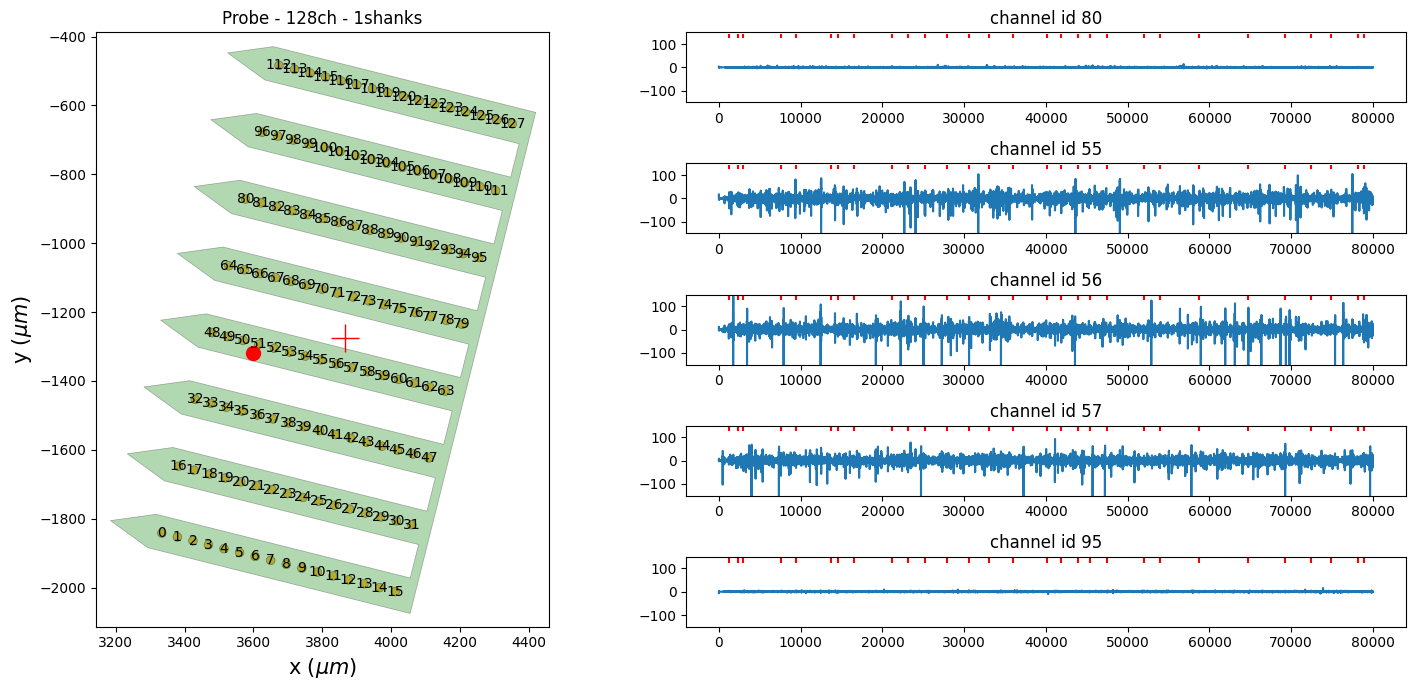

In [23]:
# set parameters
N_SAMPLE = 80000
CHANNEL_ID = [80, 55, 56, 57, 95]
MIN_MAX_AMPLITUDE = [-150, 150]

# setup plot
fig = plt.figure(figsize=(15,7));
spec = fig.add_gridspec(len(CHANNEL_ID), 2);

# plot the unit's location with respect to the probe
ax = fig.add_subplot(spec[:, 0]);
plot_probe(probe.to_2d(axes='xy'), ax=ax, with_channel_index=True);

# plot the unit's estimated location from the "center of mass" method
ax.plot(most_active_unit_estimated_loc[0], most_active_unit_estimated_loc[1], "r+", markersize=20);

# plot the unit's true location
ax.plot(most_active_unit_true_loc.x, most_active_unit_true_loc.y, "r.", markersize=20);

print("Selected neuron's estimated location (red cross) and true location (red dot)")

# get most active unit's spike train
most_active_unit_spikes = sorting_object.get_unit_spike_train(unit_id = most_active_unit_id)
most_active_unit_spikes = most_active_unit_spikes[most_active_unit_spikes<N_SAMPLE]

# plot unit spikes against nearby channels' traces
for ix in range(len(CHANNEL_ID)):
    ax = fig.add_subplot(spec[ix, 1]);
    trace = preprocessed_traces.get_traces()[:N_SAMPLE, CHANNEL_ID[ix]]
    ax.plot(trace);
    ax.eventplot(most_active_unit_spikes, linelengths = 20, lineoffsets=MIN_MAX_AMPLITUDE[1]*0.9, colors="r");    
    ax.set_title(f"channel id {CHANNEL_ID[ix]}")
    ax.set_ylim(MIN_MAX_AMPLITUDE)
plt.tight_layout();

## Validate its waveform

In [25]:
# custom functions
def get_unit_waveform(trace, spike_time, sampling_freq=20000, min_before=0.002, max_after=0.002):
    n_sample_before = min_before * sampling_freq
    n_sample_after = max_after * sampling_freq
    waveform = []
    for spike in spike_time:
        this_waveform = trace[int(spike - n_sample_before) : int(spike + n_sample_after)]
        waveform.append(this_waveform)
    return np.array(waveform).T

def plot_unit_waveform_by_channel_custom(unit_spike, channel_id=[55, 56, 57], min_max_amplitude=[-50, 20]):

    # plot waveforms
    fig = plt.figure(figsize=(5,10));
    n_channels = len(channel_id)
    for ix in range(n_channels):
        ax = fig.add_subplot(n_channels,1,ix+1);
        trace = preprocessed_traces.get_traces()[:N_SAMPLE,channel_id[ix]];
        unit_waveform = get_unit_waveform(trace, unit_spike, sampling_freq=20000, min_before=0.002, max_after=0.002);
        ax.plot(unit_waveform);
        ax.set_title(f"channel {channel_id[ix]}")
        ax.set_ylim(min_max_amplitude)
    plt.tight_layout()
    return fig

def plot_unit_waveform_by_channel_with_SI(preprocessed_traces, sorting_object, waveform_path, unit_id, channel_id=[48, 55, 56, 57, 63], min_max_amplitude=[-200, 100]):
    
    # create waveform extractor to localize unit 
    WaveformExtractor = si.extract_waveforms(preprocessed_traces, sorting_object, waveform_path,
                          load_if_exists=True, overwrite=False,
                          ms_before=2, ms_after=2., max_spikes_per_unit=None)

    # get unit waveforms (n_spikes, n_sample, n_channels)
    wfs = WaveformExtractor.get_waveforms(unit_id);    
    fig = plt.figure(figsize=(5,10));
    n_channels = len(channel_id)
    for ix in range(n_channels):
        ax = fig.add_subplot(n_channels,1,ix+1);
        ax.plot(wfs[:,:,channel_id[ix]].T);
        ax.set_title(f"channel {channel_id[ix]}")
        ax.set_ylim(min_max_amplitude)
    return fig

We plot the unit waveforms directly with the Waveform extractor.


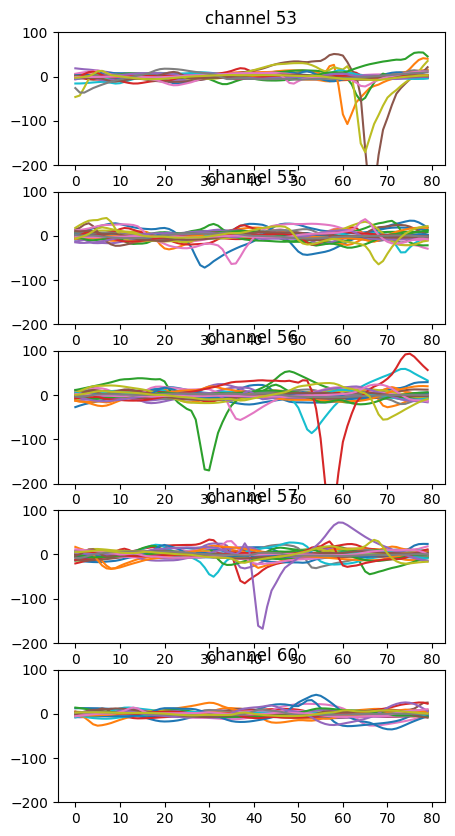

In [26]:
# plot directly with the Waveform extractor
fig = plot_unit_waveform_by_channel_with_SI(preprocessed_traces, sorting_object, config["dataset_conf"]["input"]["waveform_path"], most_active_unit_id, channel_id=[53, 55, 56, 57, 60], min_max_amplitude=[-200, 100])

We reproduced the plot with custom code to validate what's going on in the background.


spikes (color)


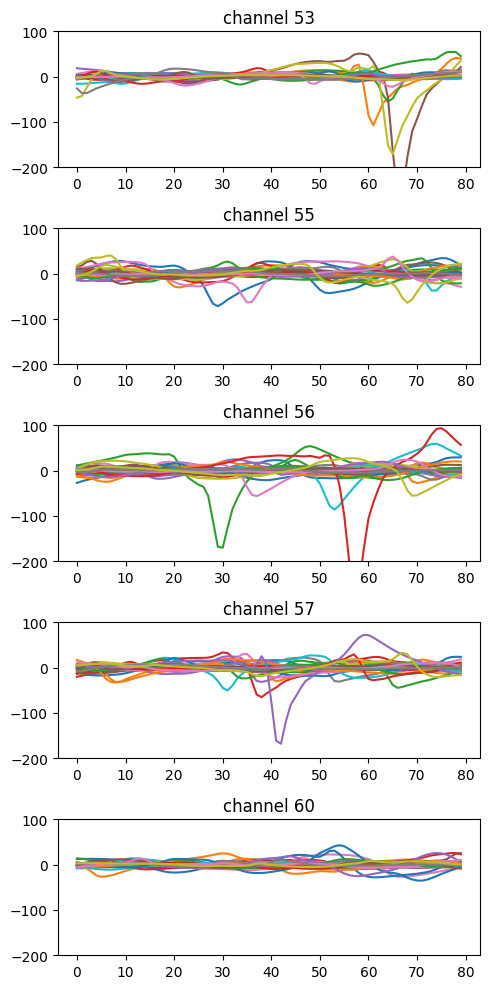

In [27]:
# reproduce plot with custom code to validate what's going on in the background
fig = plot_unit_waveform_by_channel_custom(most_active_unit_spikes, channel_id=[53, 55, 56, 57, 60], min_max_amplitude=[-200, 100])
print("spikes (color)")

We plot its median waveforms by channel.

1364637 : (29, 80, 128)
(80, 128)
channels (color)


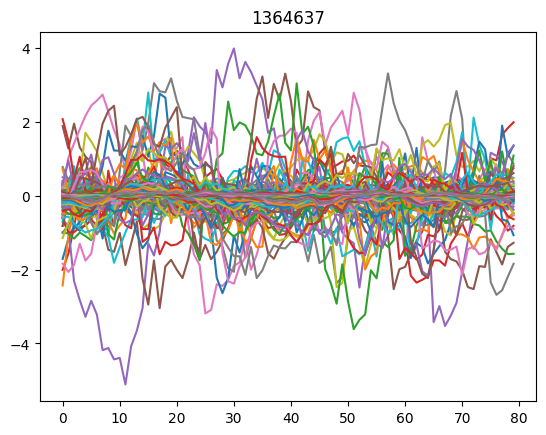

In [29]:
# get unit waveforms (n_spikes, n_sample, n_channels)
wfs = WaveformExtractor.get_waveforms(most_active_unit_id);
print(most_active_unit_id, ':', wfs.shape);

# plot unit median waveforms by channel
fig, ax = plt.subplots();
template = WaveformExtractor.get_template(unit_id=most_active_unit_id, mode='median');
print(template.shape);
ax.plot(template);
ax.set_title(f'{most_active_unit_id}');

print("channels (color)")

# References

(1) https://probeinterface.readthedocs.io/en/stable/examples/ex_05_device_channel_indices.html 

(2) https://spikeinterface.readthedocs.io/en/latest/modules/core/plot_4_waveform_extractor.html 